# Project: Image Re-colorization using Unsupervised Model to People with Color Vision Deficiency (CVD)

## Libraries & Dependencies

In [76]:
# dependencies
# pip install scikit-image
# pip install colormap
# pip install easydev

In [99]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from colormap import rgb2hex
from colorblind import colorblind
from sklearn.metrics import silhouette_score
from daltonize import daltonize

%matplotlib inline

---

## Get and Show Images

In [4]:
def get_image_rgb(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [5]:
def show_image(image):
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(image)
    plt.show();

In [58]:
def show_layers(image):
    fig, axs = plt.subplots(1,4, figsize=(16,6))
    
    axs[0].imshow(image[:,:,0]/255, cmap = 'Reds')
    axs[1].imshow(image[:,:,1]/255, cmap = 'Greens')
    axs[2].imshow(image[:,:,2]/255, cmap = 'Blues')
    axs[3].imshow(image)
    
    axs[0].set_title('Red')
    axs[1].set_title('Green')
    axs[2].set_title('Blue')
    axs[3].set_title('All')
    
    axs[0].axis("off")
    axs[1].axis("off")
    axs[2].axis("off")
    axs[3].axis('off')
    
    plt.show();

In [68]:
image2 = get_image_rgb('color_test_3.jpg')
image3 = get_image_rgb('colorblind_test.jpg')
image4 = get_image_rgb('color_test_4.jpg')
image5 = get_image_rgb('color_test_5.jpg')
image6 = get_image_rgb('color_test_6.jpg')

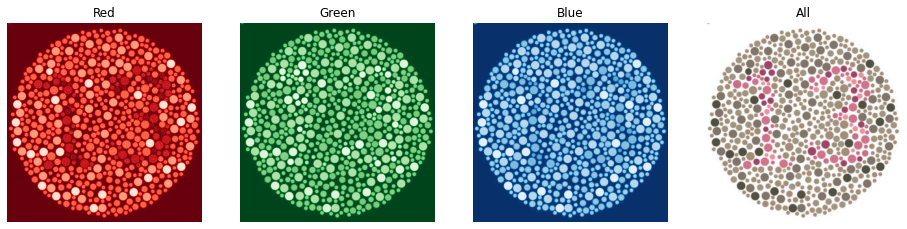

In [60]:
show_layers(image2)

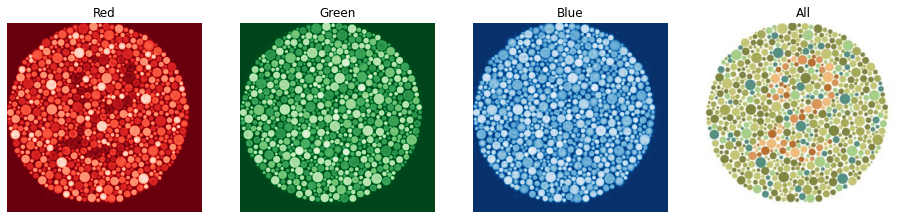

In [61]:
show_layers(image3)

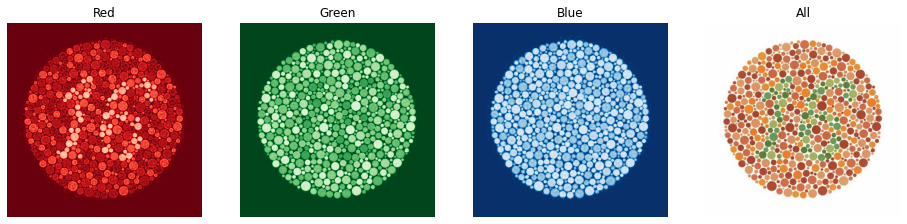

In [62]:
show_layers(image4)

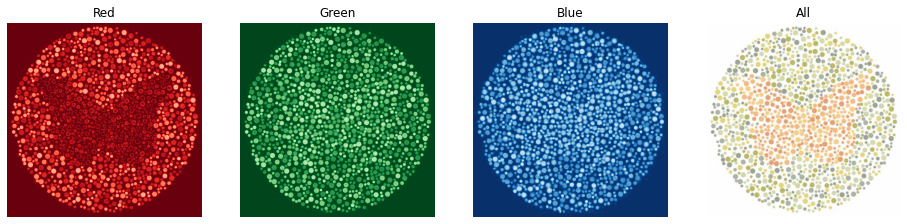

In [63]:
show_layers(image5)

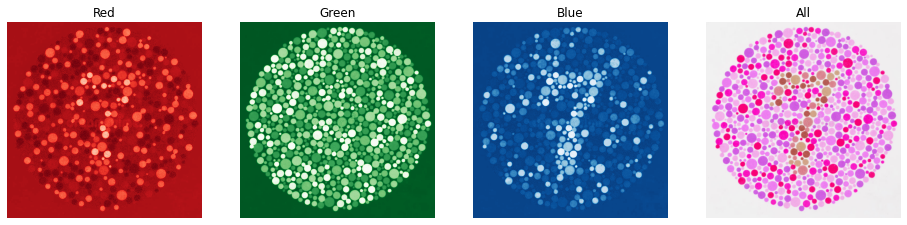

In [64]:
show_layers(image6)

---

## KMeans Clustering to Extract Major Colors

In [6]:
def get_colors(image,num_of_colors):

  mod_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
  mod_image = mod_image.reshape(mod_image.shape[0]*mod_image.shape[1], 3)

  num_of_colors = num_of_colors

  clf = KMeans(n_clusters = num_of_colors)
  labels = clf.fit_predict(mod_image)
  counts = Counter(labels)
  center_colors = clf.cluster_centers_
  ordered_colors = [center_colors[i] for i in counts.keys()]
  rgb_colors = [ordered_colors[i]/255 for i in counts.keys()]

  plt.figure(figsize = (8,6))
  plt.pie(counts.values(), colors = rgb_colors)

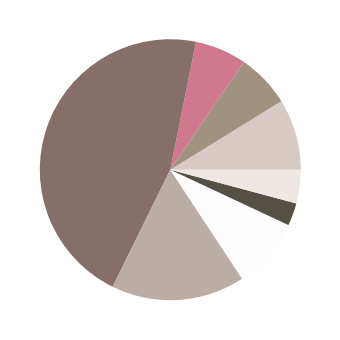

In [7]:
get_colors(image,8)

## Recoloring

In [83]:
def compare_image(image,red_img,green_img):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(36,12))
    # original photo
    ax1.imshow(image)
    ax1.axis("off")
    ax1.set_title('Original')

    # Recolored
    ax2.imshow(red_img)
    ax2.axis("off")
    ax2.set_title('Recolored - Setting Red Channel = Green')
    
    # Recolored
    ax3.imshow(green_img)
    ax3.axis("off")
    ax3.set_title('Recolored - Setting Green Channel = Red')

In [9]:
def recolor_image(image,num_color = 2):
    # Recolor image based on number of color cluster

    # reshape image to array
    reshaped_image = image.reshape(image.shape[0]*image.shape[1], 3)

    # instantiate kmeans & fit_predict
    clf = KMeans(n_clusters = num_color)
    labels = clf.fit_predict(reshaped_image)

    # count predicted labels
    counts = Counter(labels)

    # centers of colors
    center_colors = clf.cluster_centers_

    # Generating predicted class dataframe
    # reshaped image is 2D array
    pred_df = pd.DataFrame(reshaped_image,columns=['R','G','B'])
    pred_df['class'] = labels

    # RGB color of cluster center color
    new_color_df = pd.DataFrame(center_colors/255)
    new_color_df['class'] = new_color_df.index

    # Merging original color and class with new color
    image_df = pd.merge(pred_df, new_color_df, 
                    how='left', 
                    on='class')

    # Reshape recolored image
    recolored_image = image_df[[0,1,2]].to_numpy().reshape(image.shape[0],image.shape[1],3)

    compare_image(image,recolored_image)

---

## Converting RGB values

In [10]:
# Protan can perceive red so let's convert red to green

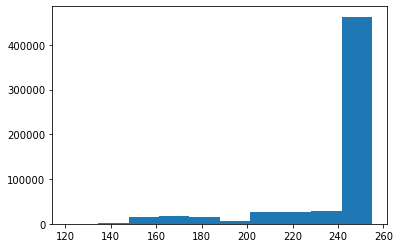

In [92]:
plt.hist(pd.Series(image[:,:,0].flatten()));

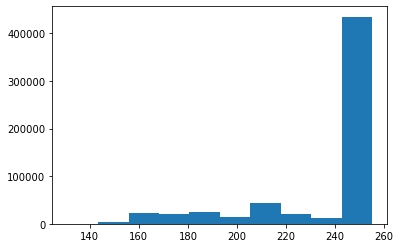

In [97]:
plt.hist(pd.Series(image[:,:,1].flatten()));

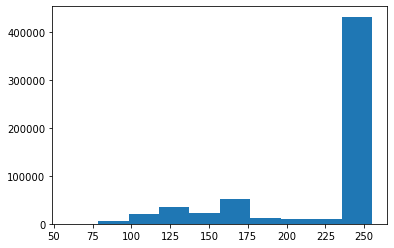

In [98]:
plt.hist(pd.Series(image[:,:,2].flatten()));

In [93]:
def intensify_red(input_image):
    copy = input_image.copy()
    for cols in copy[:,:,0]:
        for pixel in cols:
            if pixel != 255:
                pixel = 0
            else:
                pixel = 255
    return copy

In [94]:
def intensify_green(input_image):
    copy = input_image.copy()
    for cols in copy[:,:,1]:
        for pixel in cols:
            if pixel != 255:
                pixel = 0
            else:
                pixel = 255
    return copy

In [95]:
red_img = intensify_red(image1)
green_img = intensify_green(image1)

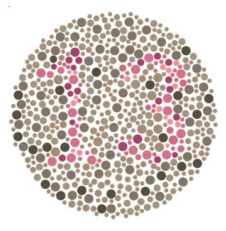

In [107]:
image1_plt = plt.imread('color_test_3.jpg')
plt.imshow(image1_plt)
plt.axis("off")
plt.show();

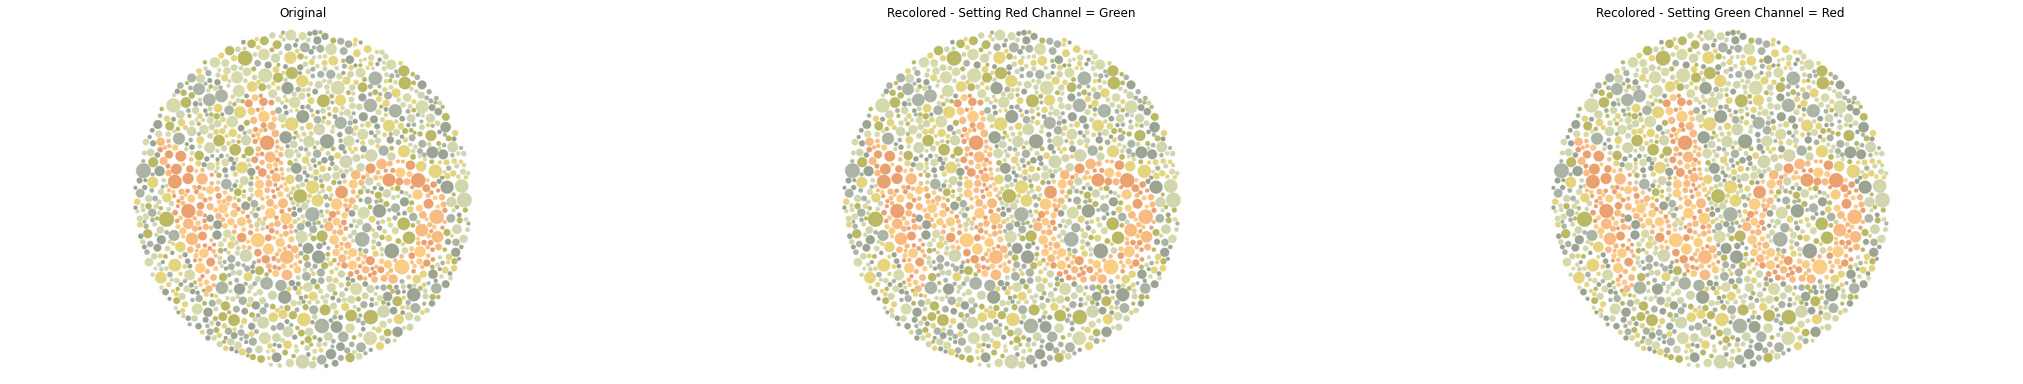

In [96]:
compare_image(image1,red_img,green_img)

---

## Color Identify and Group

In [15]:
color_df = pd.read_csv('color-names/output/colors.csv', header = None)

In [16]:
color_df.columns = ['name','name_2','hex','R','G','B']

In [17]:
color_df

,name,name_2,hex,R,G,B
0,air_force_blue_raf,Air Force Blue (Raf),#5d8aa8,93,138,168
1,air_force_blue_usaf,Air Force Blue (Usaf),#00308f,0,48,143
2,air_superiority_blue,Air Superiority Blue,#72a0c1,114,160,193
3,alabama_crimson,Alabama Crimson,#a32638,163,38,56
4,alice_blue,Alice Blue,#f0f8ff,240,248,255
...,...,...,...,...,...,...
860,yellow_orange,Yellow Orange,#ffae42,255,174,66
861,yellow_process,Yellow (Process),#ffef00,255,239,0
862,yellow_ryb,Yellow (Ryb),#fefe33,254,254,51
863,zaffre,Zaffre,#0014a8,0,20,168


In [18]:
X_train = color_df[['R','G','B']]

In [65]:
# KMeans to cluster up colors
k_list = []
sil_list = []
inertia_list = []

for num in range(2,200,2):
    clf = KMeans(n_clusters = num)
    label = clf.fit_predict(X_train)
    k_list.append(num)
    sil_list.append(silhouette_score(X_train,label))
    inertia_list.append(clf.inertia_)

In [69]:
results = pd.DataFrame({'k':k_list,'sil_score':sil_list,'inertia':inertia_list})
results.head(25)

,k,sil_score,inertia
0,2,0.298948,1.135289e+07
1,4,0.318358,6.463273e+06
2,6,0.315145,4.649960e+06
3,8,0.310832,3.817190e+06
4,10,0.289846,3.272838e+06
5,12,0.291184,2.856725e+06
6,14,0.297785,2.491406e+06
7,16,0.294901,2.252899e+06
8,18,0.293521,2.076652e+06
9,20,0.300228,1.856616e+06


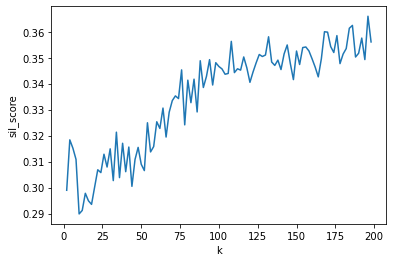

In [67]:
sns.lineplot(x='k',y='sil_score', data=results);

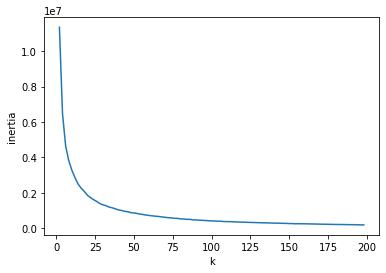

In [68]:
sns.lineplot(x='k',y='inertia', data=results);

In [152]:
def recolor_by_cluster(image,num_clusters = 16):
    
    # clustering
    clf = KMeans(n_clusters = num_clusters, random_state = 42)
    label = clf.fit_predict(X_train)
    center_colors = clf.cluster_centers_.round().astype(int)
    center = pd.DataFrame(center_colors)
    center['class'] = center.index
    
    # reshape
    reshaped_image = image.reshape(image.shape[0]*image.shape[1], 3)
    class_pred = clf.predict(reshaped_image)
    original_df = pd.DataFrame(reshaped_image,columns=['R','G','B'])
    original_df['class'] = class_pred
    
    # recolor
    recolor_df = pd.merge(original_df, center, how='left', on='class')
    recolored_image = recolor_df[[0,1,2]].to_numpy().reshape(image.shape[0],image.shape[1],3)
    
    # image showing
    show_image(recolored_image)

C:\Users\smile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


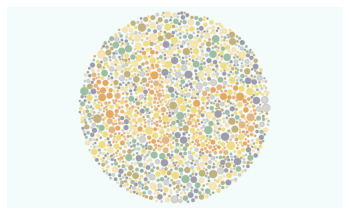

In [182]:
recolor_by_cluster(image,num_clusters=150)